<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [3]:
import random
import numpy as np
from tqdm import tqdm
from time import time

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import qini_auc_score
from sklearn.metrics import make_scorer

from libraries.psi import calculate_psi

Failed to import duecredit due to No module named 'duecredit'


#### 1.1 Загрузка и первичная обработка данных

In [4]:
features = pd.read_csv('data/AGGS_FINAL.csv', index_col=0)
contracts = pd.read_csv('data/CONTRACTS_FINAL.csv', index_col=0)
campaigns = pd.read_csv('data/CAMPAINGS.csv', index_col=0)
people_in_campaigns = pd.read_csv('data/PEOPLE_IN_CAMPAINGS_FINAL.csv', index_col=0)

In [5]:
features['report_dt'] = pd.to_datetime(features['report_dt'], format='%Y-%m-%d') # перевод в тип datetime
features.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [6]:
contracts['contract_date'] = pd.to_datetime(contracts['contract_date'], format='%Y-%m-%d') # перевод в тип datetime
contracts.head()

,user_id,contract_date,product_id,contract_id
39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
9286,103088,2024-11-13,1,0001_2024-11-13_103088
45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
150378,52269,2024-11-17,1,0001_2024-11-17_52269


In [7]:
campaigns.head()

,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


In [8]:
people_in_campaigns.delivery_date = pd.to_datetime(people_in_campaigns.delivery_date, format='%Y-%m-%d', errors='coerce') # перевод в тип datetime
people_in_campaigns.head()

,campaing_id,user_id,t_flag,delivery_date
29299,idclip,1099975,1,2024-11-06
36627,iddqd,1162,1,2024-11-08
134015,iddqd,42991,1,2024-11-07
57441,idclip,142343,0,NaT
48671,iddqd,24623,0,NaT


#### 1.2 Анализ пересечений кампаний

In [9]:
def find_people_in_campaigns(df, campaign):
    people_in_campaigns = df[df.campaing_id == campaign]['user_id']
    return set(people_in_campaigns)

def print_people_counts():
    people_in_iddqd = find_people_in_campaigns(people_in_campaigns, 'iddqd')
    people_in_idclip = find_people_in_campaigns(people_in_campaigns, 'idclip')
    people_in_iddt = find_people_in_campaigns(people_in_campaigns, 'iddt')
    people_in_idkfa = find_people_in_campaigns(people_in_campaigns, 'idkfa')

    print(f'people_in_iddqd: {len(people_in_iddqd)}')
    print(f'people_in_idclip: {len(people_in_idclip)}')
    print(f'people_in_iddt: {len(people_in_iddt)}')
    print(f'people_in_idkfa: {len(people_in_idkfa)}')

In [10]:
print_people_counts()

people_in_iddqd: 160000
people_in_idclip: 120000
people_in_iddt: 120000
people_in_idkfa: 120000


Удалим из таблицы `people_in_campaigns` те `user_id`, которые встречаются больше одного раза

In [11]:
user_counts = people_in_campaigns.user_id.value_counts()
unique_users = user_counts[user_counts == 1].index
people_in_campaigns = people_in_campaigns[people_in_campaigns.user_id.isin(unique_users)]

In [12]:
print_people_counts()

people_in_iddqd: 100000
people_in_idclip: 60000
people_in_iddt: 120000
people_in_idkfa: 120000


In [13]:
people_in_campaigns[people_in_campaigns.campaing_id == 'idclip'].t_flag.unique()

array([1], dtype=int64)

Множество людей, участвовавших к кампании `idclip` наполовину пересекается с участниками кампании `iddqd`. Кроме того, что уже удалили пользователей, учавствовавших в двух и более кампаниях, стоит также удалить кампанию `idclip` из рассмотрения. Так ка у нее не осталось контрольной группы

In [14]:
people_in_campaigns = people_in_campaigns[people_in_campaigns.campaing_id != 'idclip']

#### 1.3 Объединение таблиц

In [15]:
# Функция для определения целевого события
def calculate_target(row):
    if row['t_flag'] == 1:  # Целевая группа
        if pd.notnull(row['contract_date']) and (row['contract_date'] - row['delivery_date']).days <= 14:
            return 1
    elif row['t_flag'] == 0:  # Контрольная группа
        if pd.notnull(row['contract_date']) and (row['contract_date'] - pd.to_datetime('2024-11-01',  format='%Y-%m-%d')).days <= 21:
            return 1
    return 0

In [16]:
# Шаг 1: Объединяем people_in_campaings и campaings
# Добавляем информацию о каналах и продуктах
campaigns_data = people_in_campaigns.merge(
    campaigns,
    on='campaing_id',
    how='left'
)

# Шаг 2: Добавляем информацию о покупках из contracts
# Фильтруем покупки только для айтема 1
contracts_filtered = contracts[contracts['product_id'] == 1]
campaigns_data = campaigns_data.merge(
    contracts_filtered,
    on='user_id',
    how='left'
)
final_data = campaigns_data

# Применяем функцию для расчета целевого события
final_data['target'] = final_data.apply(calculate_target, axis=1)

# Почистим от ненужных столбцов
final_data = final_data.drop(['campaing_id', 
                              'delivery_date', 
                              'product_id_x', 
                              'contract_date', 
                              'product_id_y', 
                              'contract_id'], 
                              axis = 1)

print(f'Размер датасета: {final_data.shape}')
final_data.head()

Размер датасета: (340000, 4)


,user_id,t_flag,channel,target
0,24623,0,push,0
1,4001330,0,banner,0
2,2008409,1,other_ads,1
3,4045746,1,banner,1
4,2101471,0,other_ads,1


In [17]:
base_uplift = {}
for channel in final_data.channel.unique():
    t_flag_1 = final_data[(final_data.channel==channel)&(final_data.t_flag == 1)].target.mean()
    t_flag_0 = final_data[(final_data.channel==channel)&(final_data.t_flag == 0)].target.mean()
    base_uplift[channel] = t_flag_1 - t_flag_0
pd.DataFrame.from_dict(data = base_uplift, orient='index', columns = ['base_uplift'])

,base_uplift
push,0.491200
banner,0.287017
other_ads,0.301533


#### 1.4 Выводы

В ходе анализа данных по кампаниям нашлось 60000 человек, которые принимали участие в двух кампаниях сразу (sms и push). После удаления этих пользователей от sms кампании не осталось пользователей из контрольной группы (`t_flag == 0`), поэтому sms кампанию полностью исключили из рассмотрения.

При объединении данных и формировании таргета получили датасет размером `(340000, 4)` и столбцами `user_id`, `t_flag`, `channel` и `target`

Самый высокий базовый uplift у push - 0.49, самый низкий у banners - 0.29

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

#### 2.1 Присоединение пользовательских фич

При этом можно сразу закодировать столбец `city` OHE (по хорошему, конечно, нужно это делать отдельно для train и test, но в данном случае всго три уникальных значения, поэтому страшной утечки не должно произойти)

In [18]:
features_filtered = features[features['report_dt'].dt.to_period('M').dt.start_time == pd.to_datetime('2024-09-01')].drop('report_dt', axis=1) # пользователи только за сентябрь

df = final_data.merge(
    features_filtered,
    on='user_id',
    how='left'
)
encoder = OneHotEncoder(dtype='int', drop='first')

one_hot_encoded = encoder.fit_transform(df[['city']]).toarray()

one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['city']))

df = pd.concat([df.drop('city', axis=1), one_hot_df], axis=1)

df.to_csv('df.csv', index=False) # Сохраняем на всякий случай

df.head()

,user_id,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city_Smolensk,city_Ufa
0,24623,0,push,0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,0,1
1,4001330,0,banner,0,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,30,1,0
2,2008409,1,other_ads,1,-1.952636,-0.479671,1.067760,-1.521329,-0.687298,0.327018,1.052708,1.244605,-0.886796,25,0,0
3,4045746,1,banner,1,1.768029,-1.560275,0.533826,-1.815031,-0.456184,0.274609,0.077484,0.452296,-0.224605,21,0,1
4,2101471,0,other_ads,1,2.365226,-1.303713,0.133301,2.098386,-0.000000,0.285846,0.545567,0.293677,-0.312559,36,0,1


#### 2.2 Базовый EDA

Проверим, нет ли пропусков

In [19]:
missing_values = df.isna().sum().to_frame('Missing Values').T
missing_values.columns.name = 'Column'
missing_values.index = ['Missing Values']
missing_values

Column,user_id,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city_Smolensk,city_Ufa
Missing Values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим, насколько различия между значениями признаков целевой и контрольной группы статистически значимы (полагаем уровень статзначимости 0.05)

In [20]:
x_col = df.columns.drop(['t_flag', 'channel', 'target', 'user_id'])
results = pd.DataFrame(index=df['channel'].unique(), columns=x_col)

for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel]
    for col in x_col:
        psi = calculate_psi(
            expected=channel_data[channel_data['t_flag'] == 0][col],
            actual=channel_data[channel_data['t_flag'] == 1][col]
        )
        results.at[channel, col] = psi
results

Column,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city_Smolensk,city_Ufa
push,0.001583,0.000658,0.000579,0.001788,0.000832,0.000778,0.000479,0.000133,0.000381,0.001023,0.00022,0.000048
banner,0.000375,0.00029,0.00018,0.000105,0.000243,0.000151,0.000401,0.000378,0.000403,0.000197,0.0,0.000017
other_ads,0.000375,0.00029,0.00018,0.000105,9.209419,0.000151,0.000401,0.000378,0.000403,0.000143,0.294799,0.098554


Есть вопросы к признаку `x5` кампании `other_ads`

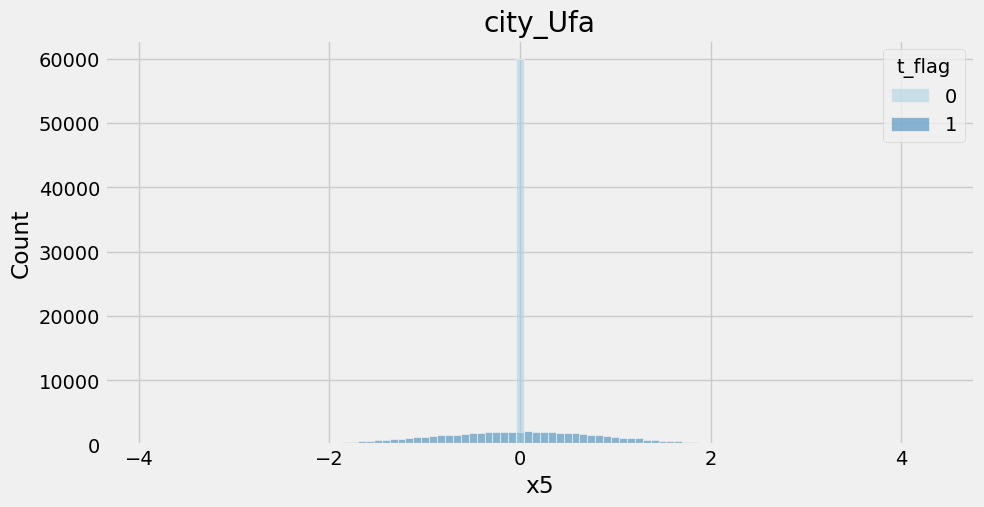

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(data = df[df.channel == 'other_ads'], x='x5', hue='t_flag', bins=100).set_title(col)
plt.show()

Очевидно, что тестовая и контрольная группа из разных выборок. Есть два варианта - удалить признак или удалить целую кампанию. Так как с остальными признаками все отлично, то жалко удалять хорошую кампанию

In [22]:
df = df.drop('x5', axis=1)

### ваши выводы здесь

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [23]:
channels = df['channel'].unique()

In [24]:
features_cols = df.columns.drop(['channel', 'target', 'user_id', 't_flag'])
sc = StandardScaler()

# Создаем ColumnTransformer для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_cols)
    ])

qini_scorer = make_scorer(qini_auc_score, greater_is_better=True)

In [25]:
skf = StratifiedKFold(n_splits=2,
                      random_state=42,
                      shuffle=True)

In [26]:
model_1_cb = CatBoostClassifier(verbose=0, random_seed=42, thread_count=-1)
model_2_cb = CatBoostClassifier(verbose=0, random_seed=142, thread_count=-1)

calib_model_1 = CalibratedClassifierCV(estimator=model_1_cb, method='isotonic', cv=skf)
calib_model_2 = CalibratedClassifierCV(estimator=model_2_cb, method='isotonic', cv=skf)

In [27]:
# Пайплайн для SoloModel
pipeline_solo = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SoloModel(model_1_cb))
])

# Параметры для тюнинга
param_grid_solo = {
    'model__estimator__depth': [2, 8, 10]
}

# Поиск гиперпараметров
grid_search_solo = GridSearchCV(pipeline_solo, param_grid_solo, scoring=qini_scorer, cv=3)

# Пайплайн для TwoModel с калибровкой
pipeline_two = Pipeline([
    ('preprocessor', preprocessor),
    ('model', TwoModels(
        estimator_trmnt=calib_model_1,
        estimator_ctrl=calib_model_2,
        method='ddr_control'
    ))
])
# Параметры для тюнинга
param_grid_two = {
    'model__estimator_trmnt__estimator__depth': [2, 8],
    'model__estimator_ctrl__estimator__depth': [10]
}

# Поиск гиперпараметров
grid_search_two = GridSearchCV(pipeline_two, param_grid_two, scoring=qini_scorer, cv=3)

# Пайплайн для ClassTransformation
pipeline_ct = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ClassTransformation(estimator=LogisticRegression()))
])

# Параметры для тюнинга
param_grid_ct = {
    'model__estimator__C': [0.1, 1, 10]
}

# Поиск гиперпараметров
grid_search_ct = GridSearchCV(pipeline_ct, param_grid_ct, scoring=qini_scorer, cv=3)

In [28]:
# Словарь для хранения моделей
models = {}
qini_scores = {}
results_df = pd.DataFrame(np.zeros((3, 3)), index=channels, columns=['SoloModel', 'TwoModels_calib', 'ClassTransformation'])
# Обучаем модели для каждого канала
for channel in np.array(channels):
    print(channel)
    df_channel = df[df['channel'] == channel]
    
    X = df_channel[features_cols]
    y = df_channel['target']
    treatment = df_channel['t_flag']  # Флаг целевой группы
    
    X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )
    
    # SoloModel
    start_time = time()
    grid_search_solo.fit(X_train, y_train, model__treatment=treatment_train)
    uplift_solo = grid_search_solo.predict(X_test)
    qini_solo = qini_auc_score(y_test, uplift_solo, treatment_test)
    qini_scores[f'{channel}_solo'] = qini_solo
    models[f'{channel}_solo'] = grid_search_solo.best_estimator_  # Сохраняем модель
    results_df.loc[channel, 'SoloModel'] = qini_solo
    print(f'\tSoloModel обучилась за {time() - start_time:.2f} c.')

    # TwoModel с калибровкой
    start_time = time()
    grid_search_two.fit(X_train, y_train, model__treatment=treatment_train)
    uplift_two_calibrated = grid_search_two.predict(X_test)
    qini_two_calibrated = qini_auc_score(y_test, uplift_two_calibrated, treatment_test)
    qini_scores[f'{channel}_two_calibrated'] = qini_two_calibrated
    models[f'{channel}_two_calibrated'] = grid_search_two.best_estimator_  # Сохраняем модель
    results_df.loc[channel, 'TwoModels_calib'] = qini_two_calibrated
    print(f'\tTwoModel обучилась за {time() - start_time:.2f} c.')

    # ClassTransformation
    start_time = time()
    grid_search_ct.fit(X_train, y_train, model__treatment=treatment_train)
    uplift_ct = grid_search_ct.predict(X_test)
    qini_ct = qini_auc_score(y_test, uplift_ct, treatment_test)
    qini_scores[f'{channel}_ct'] = qini_ct
    models[f'{channel}_ct'] = grid_search_ct.best_estimator_  # Сохраняем модель
    results_df.loc[channel, 'ClassTransformation'] = qini_ct
    print(f'\tClassTransformation обучилась за {time() - start_time:.2f} c.')
    print()

push
	SoloModel обучилась за 116.70 c.
	TwoModel обучилась за 371.93 c.
	ClassTransformation обучилась за 0.40 c.

banner
	SoloModel обучилась за 148.62 c.
	TwoModel обучилась за 417.09 c.
	ClassTransformation обучилась за 0.55 c.

other_ads
	SoloModel обучилась за 146.50 c.
	TwoModel обучилась за 418.84 c.
	ClassTransformation обучилась за 0.53 c.



In [29]:
for channel in channels:
    df_channel = df[df['channel'] == channel]
    
    # Признаки и целевая переменная
    X = df_channel[features_cols]
    y = df_channel['target']
    
    # Преобразуем treatment в строки
    treatment = df_channel['t_flag'].astype(str)
    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )

    # Инициализируем модель
    uplift_forest = UpliftRandomForestClassifier(control_name='0')
    
    treatment_train = treatment_train.astype('str')
    treatment_test = treatment_test.astype('str')

    # Обучаем модель
    uplift_forest.fit(
        X=X_train.values,
        y=y_train.values,
        treatment=treatment_train.values
    )
    
    # Прогнозируем uplift
    uplift_fr = uplift_forest.predict(X=X_test.values)

    qini = qini_auc_score(y_true = y_test, uplift = uplift_fr.reshape(-1), treatment = treatment_test.astype('float'))

    results_df.loc[channel, 'UpliftRandomForestClassifier'] = qini

In [30]:
results_df

,SoloModel,TwoModels_calib,ClassTransformation,UpliftRandomForestClassifier
push,0.251061,0.253405,0.166388,0.234118
banner,0.224083,0.230339,0.211158,0.187023
other_ads,0.214983,0.218016,0.211345,0.177565


<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**`
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

#### 4.1 Подготовка пользователей

Для предсказаний возьмем пользователей за январь 2025 года и для примера возьмем случайную выборку из этой совокупности

In [31]:
features_filtered = features[features['report_dt'].dt.to_period('M').dt.start_time == pd.to_datetime('2025-01-01')].drop('report_dt', axis=1) # пользователи только за сентябрь

one_hot_encoded = encoder.transform(features_filtered[['city']]).toarray()

one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['city']))

features_filtered = pd.concat([features_filtered.drop('city', axis=1), one_hot_df], axis=1)

#### 4.2 Подготовка предсказаний

Не будем отправлять клиенту комуникацию, если его наилучший uplift меньше 0.5 (как в анекдоте про блондинку и динозавра)

In [32]:
# Создаем DataFrame для хранения рекомендаций
recommendations = []
users = random.sample(sorted(features_filtered['user_id'].unique()), k=5000)
# Для каждого клиента выбираем канал с максимальным uplift
for user_id in tqdm(users):
    user_data = features_filtered[features_filtered['user_id'] == user_id].iloc[0]  # Данные клиента
    
    # Создаем DataFrame для признаков клиента
    X_user = pd.DataFrame([user_data[features_cols]], 
                          columns=features_cols)
    
    # Прогнозируем uplift для каждого канала
    uplift_scores = {}
    for channel in channels:
        model = models[f'{channel}_solo']  # Используем TwoModel с калибровкой
        uplift = model.predict(X_user)[0]

        uplift_scores[channel] = uplift
    # Выбираем канал с максимальным uplift
    best_channel = max(uplift_scores, key=uplift_scores.get)
    best_uplift = uplift_scores[best_channel]
    
    # Если uplift <= 0, рекомендуем не отправлять коммуникацию
    if best_uplift <= 0.5:
        best_channel = 'no_comm'
        best_uplift = 0.5001
    
    # Добавляем рекомендацию в таблицу
    recommendations.append({
        'user_id': user_id,
        'best_channel': best_channel,
        'best_uplift': best_uplift

    })

# Преобразуем в DataFrame
recommendations_df = pd.DataFrame(recommendations).sort_values('best_uplift', ascending=False)

# Сохраняем результат
recommendations_df.to_csv('recommendations.csv', index=False)

# Выводим первые строки
recommendations_df.head()

100%|██████████| 5000/5000 [00:29<00:00, 169.58it/s]


,user_id,best_channel,best_uplift
1434,4004112,push,0.991846
2625,66908,push,0.991845
863,4063897,push,0.991767
3873,34526,push,0.991627
710,4010557,push,0.991067


#### 4.3 Небольшой анализ

In [33]:
recommendations_df.best_channel.unique()

array(['push', 'other_ads', 'banner', 'no_comm'], dtype=object)

В рекомендациях присутсвуют разные способы коммуникации

In [34]:
# небольшой костыль для соответсвия цветов на гистограмме и круговой диаграмме
vals = recommendations_df.best_channel.value_counts()
rec_vals = {'push':vals['push'], 
            'banner':vals['banner'], 
            'other_ads':vals['other_ads'], 
            'no_comm':vals['no_comm']}

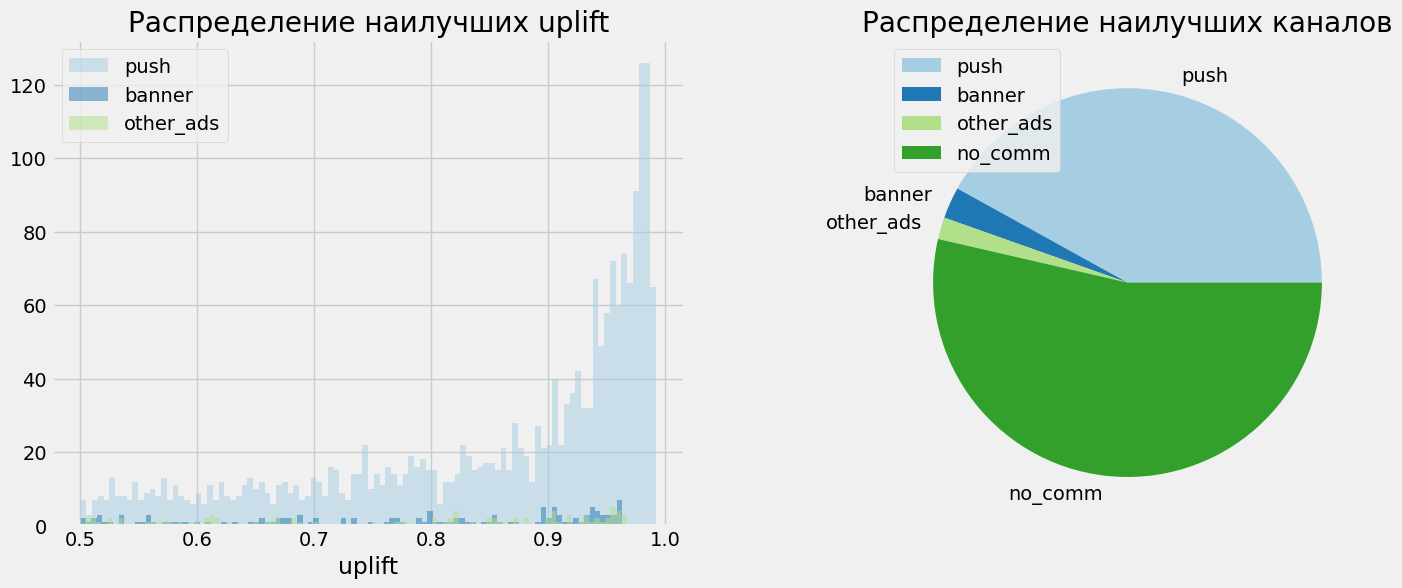

In [35]:
plt.figure(figsize=(16, 6))

for channel in channels:
    plt.subplot(1, 2, 1)
    plt.title('Распределение наилучших uplift')    
    plt.hist(recommendations_df[recommendations_df.best_channel == channel].best_uplift, bins=100, label=channel, alpha = 0.5)
    plt.legend()
plt.xlabel('uplift')
plt.subplot(1, 2, 2)
plt.title('Распределение наилучших каналов')
plt.pie(x = rec_vals.values(), labels=rec_vals.keys()) 
plt.legend() 
plt.show()

В среднем, самый лучший способ крммуникации - push уведомления

#### 4.4 Выводы

Для каждого выбранного пользователя был подобран оптимальный канал коммуникации и соответсвующий ему Uplift